# Exploratory Data Analysis

This notebook contains code to clean and analyze the metadata that will ultimately be used to monitor a dataset over time. Metadata snapshots will be captured on the updates being made to the Tyler dataset from the source system. By analyzing the patterns in the metadata, we can get a sene of what a "typical" update looks like, compated to an "atypical" one.        


Metadata to capture:

Field | Description
:--- | :---
Update Date|Date dataset was updated (in US Eastern time)
Revision Sequence | Number of the revision
Update Type|'Update' or 'Replace'
Total Rows|Count of rows in the update
Error Count|Count of rows with transforms that resulted in an error
Rows Updated|Count of updated rows in the update
Rows Created|Count of created rows in the update
Errors|Rows that failed to upsert

In [1]:
import os
import requests
import pandas as pd
import datetime
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [2]:
# Data has been pulled from a REST endpoint and written to a .csv file, which we'll read in here.
# The endpoint we've collected metadata from only keeps 20 revisions – or dataset updates – worth of data, 
# we'll take as much as we can and bootstrap the rest. 

df = pd.read_csv('./data/revisions_raw.csv')
df['update_date'] = pd.to_datetime(df['update_date']).dt.date
df['update_date'] = pd.to_datetime(df['update_date'])
df['day_of_week'] = df['update_date'].dt.day_name()
df.head()

,update_date,revision_seq,update_type,total_rows,rows_updated,rows_created,errors,day_of_week
0,2023-08-01,748,update,40286,12278,28008,0,Tuesday
1,2023-07-31,747,update,1511,93,1396,22,Monday
2,2023-07-30,746,update,2333,1591,742,0,Sunday
3,2023-07-29,745,update,39217,13172,25952,93,Saturday
4,2023-07-28,744,update,43273,14368,28899,6,Friday


#### EDA

In [3]:
df.dtypes

update_date     datetime64[ns]
revision_seq             int64
update_type             object
total_rows               int64
rows_updated             int64
rows_created             int64
errors                   int64
day_of_week             object
dtype: object

In [4]:
df[[col for col in df.columns if col != 'revision_seq']].describe()

,update_date,total_rows,rows_updated,rows_created,errors
count,20,20.000,20.000,20.000,20.000
mean,2023-07-22 12:00:00,29599.450,9262.050,20323.400,14.000
min,2023-07-13 00:00:00,1327.000,0.000,742.000,0.000
25%,2023-07-17 18:00:00,2500.250,1475.000,1500.250,0.750
50%,2023-07-22 12:00:00,40124.500,12088.000,27841.500,6.000
75%,2023-07-27 06:00:00,42772.750,13377.250,29046.250,10.000
max,2023-08-01 00:00:00,44016.000,14816.000,30986.000,93.000
std,NaN,18729.524,5920.923,12877.728,24.251


In [5]:
# Create an axis label for plotting
df['axis_label'] = df['day_of_week'] + " " + df['update_date'].apply(lambda x: str(x)[:10])

In [6]:
continuous_vars = ['total_rows', 'rows_updated', 'rows_created', 'errors']

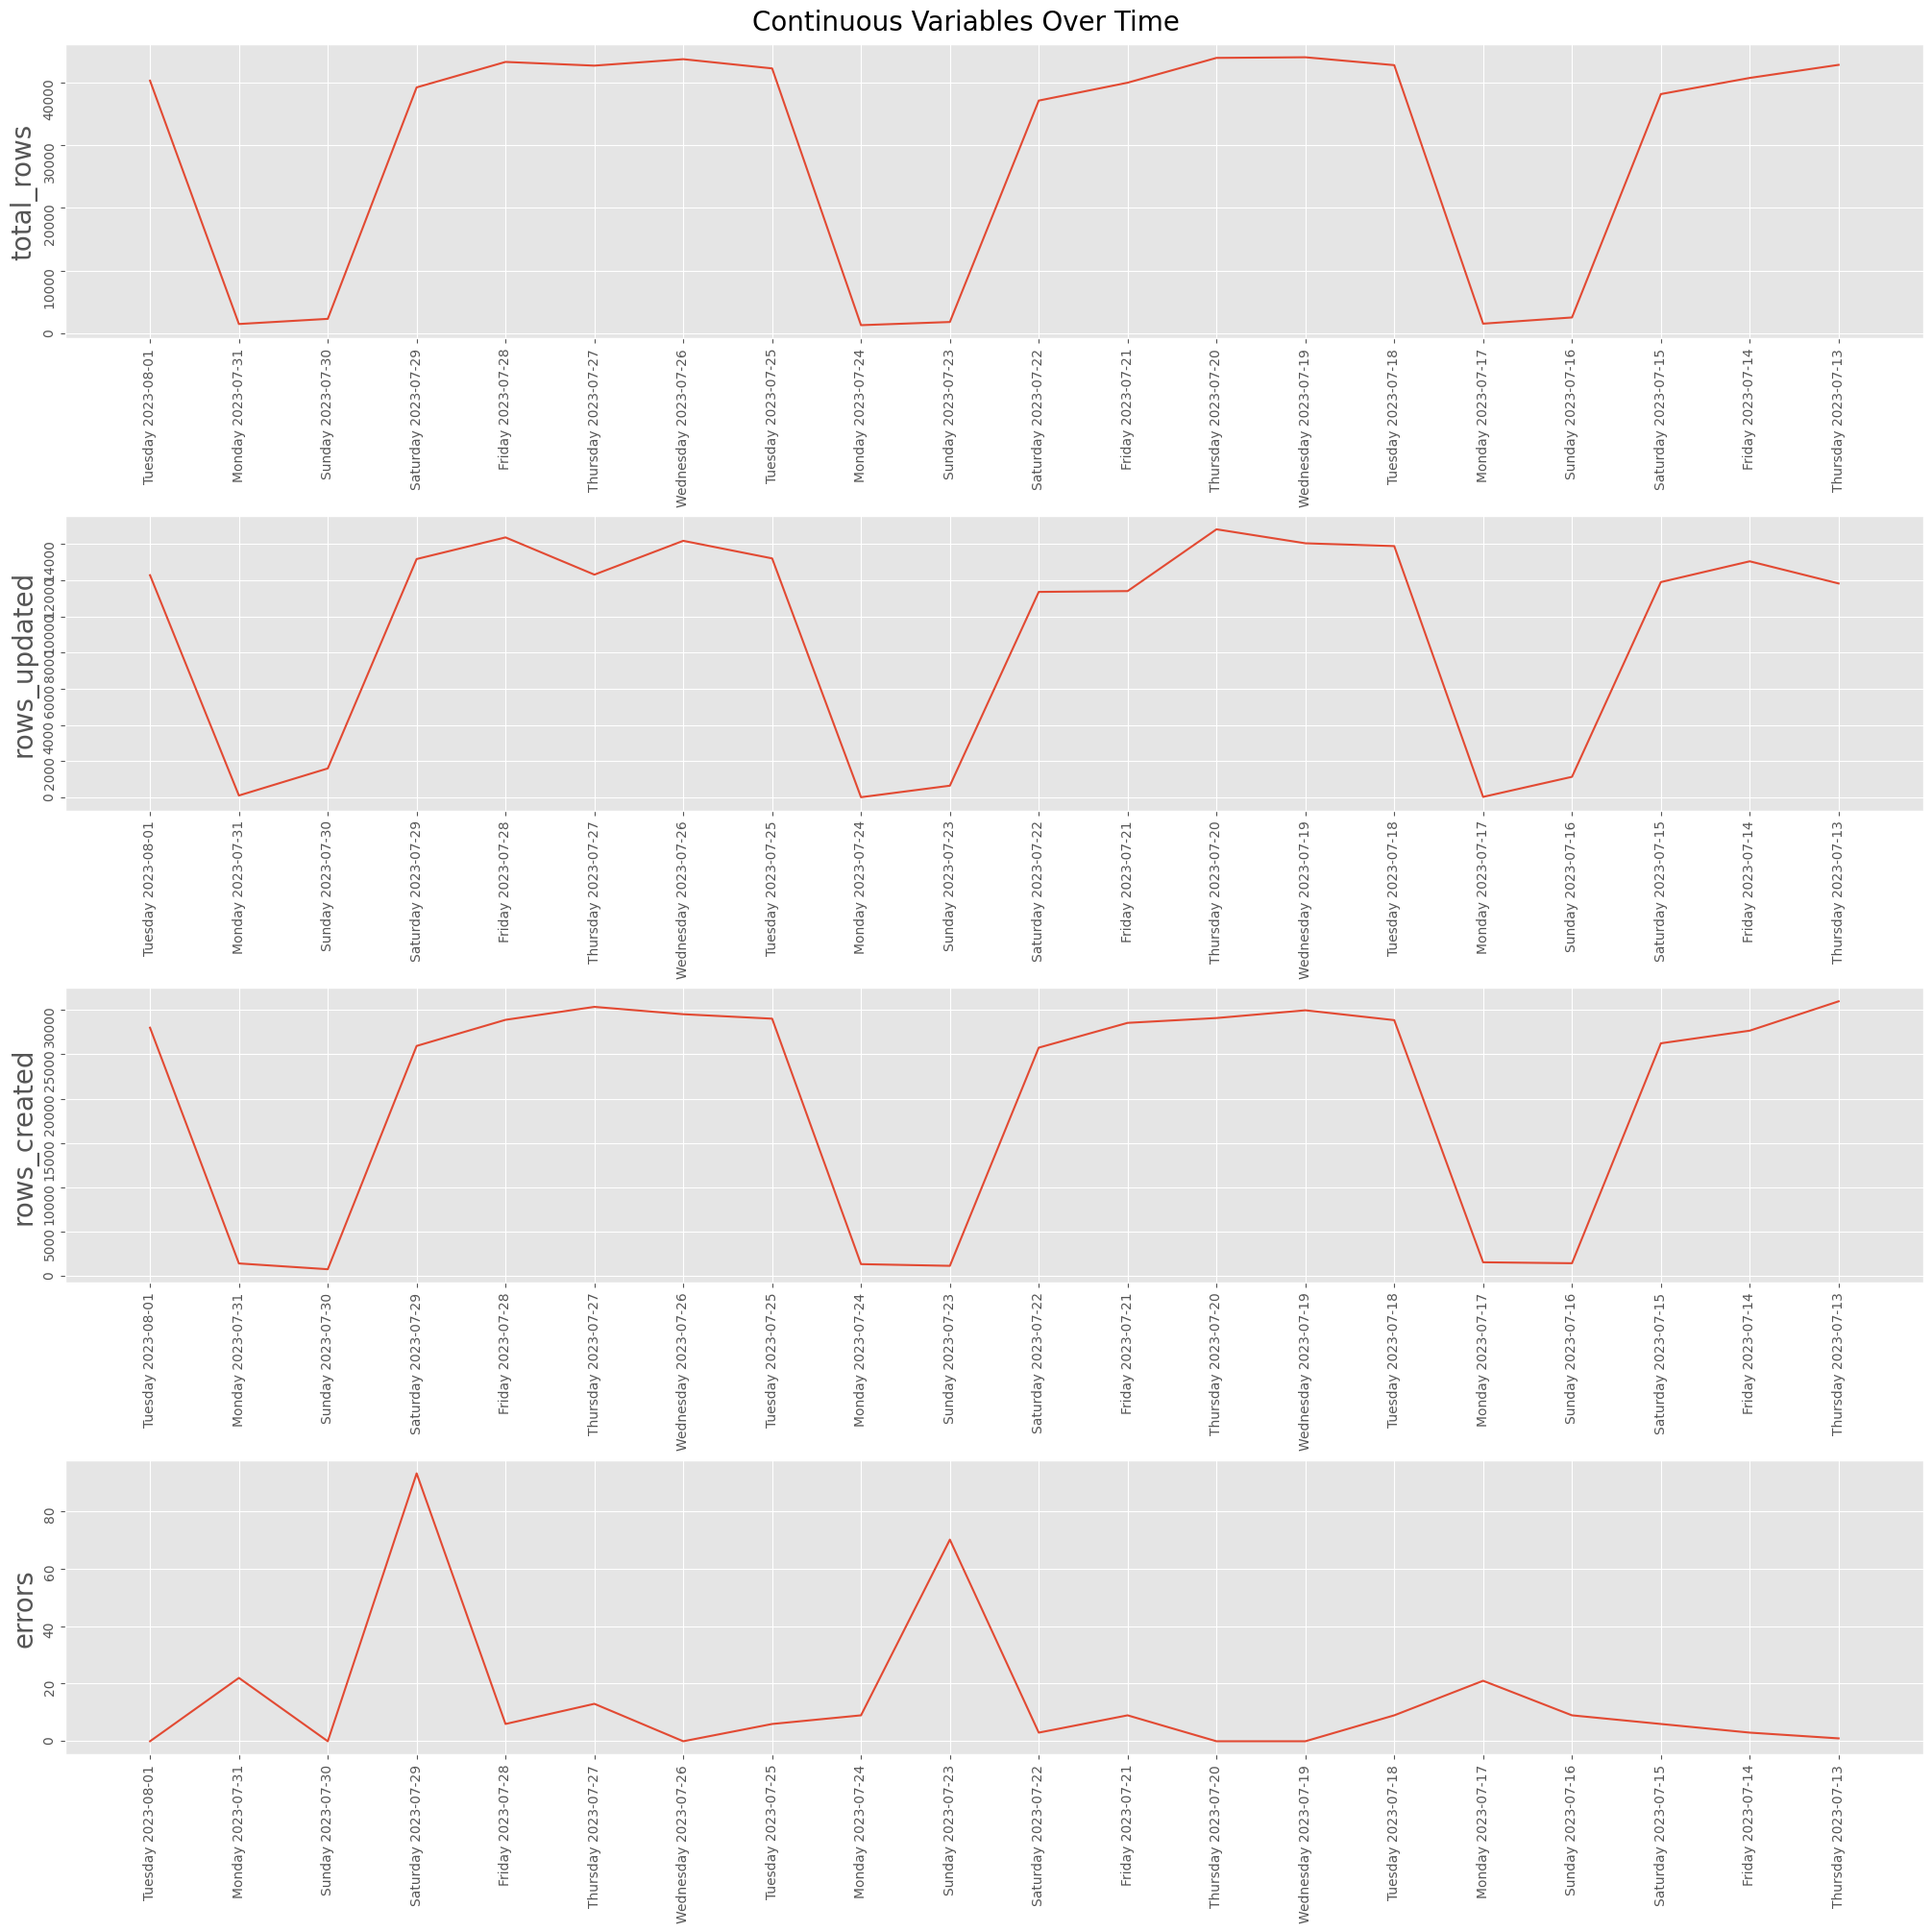

In [7]:
# Distribution plots
fig, axs = plt.subplots(4, figsize=(20, 20), constrained_layout = True)
fig.suptitle('Continuous Variables Over Time', fontsize = 20)

for figure, variable in enumerate(continuous_vars):
    axs[figure].plot(df['axis_label'], df[variable])
    for tick in axs[figure].xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
        axs[figure].tick_params(labelrotation=90)

    axs[figure].set_ylabel(variable, fontsize = 20)


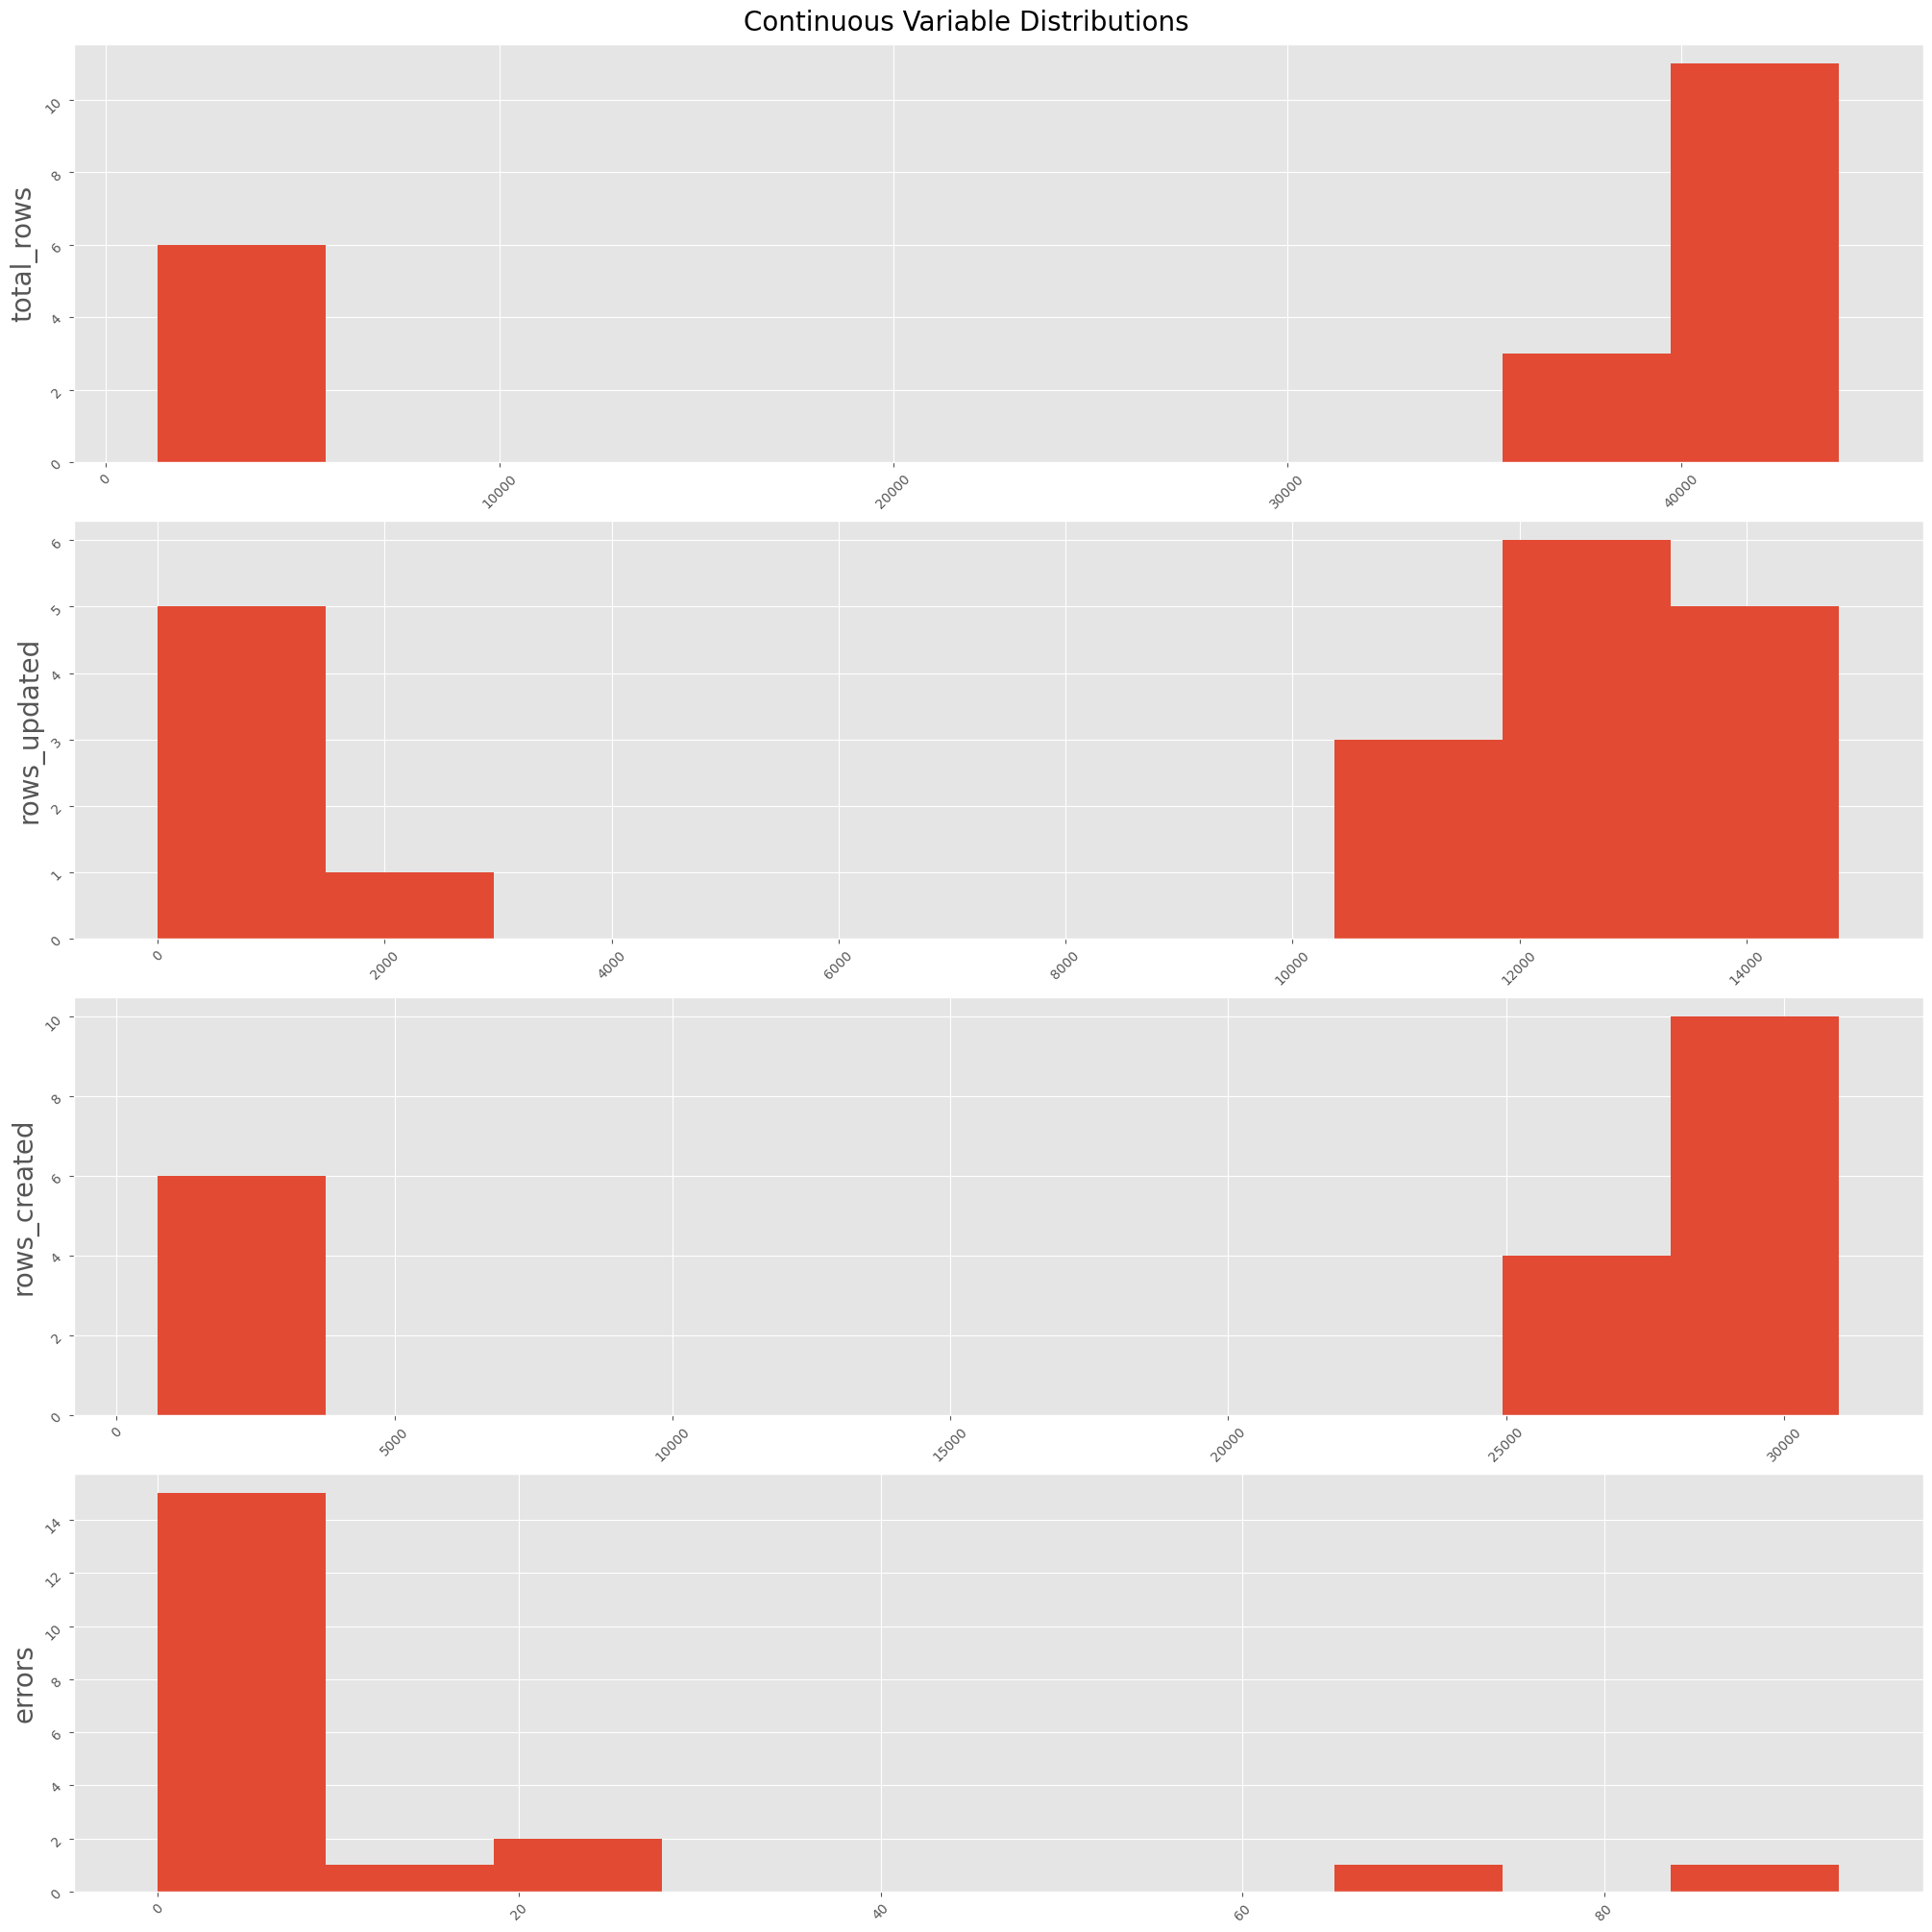

In [8]:
fig, axs = plt.subplots(4, figsize=(20, 20), constrained_layout = True)
fig.suptitle('Continuous Variable Distributions', fontsize = 20)

for figure, variable in enumerate(continuous_vars):
    
#     # UNCOMMENT for a notched boxplot:
#     axs[figure].boxplot(df[variable], notch=True)
    
    # UNCOMMENT for histogram:
    axs[figure].hist(df[variable])
    axs[figure].tick_params(labelrotation=45)

    axs[figure].set_ylabel(variable, fontsize = 20)

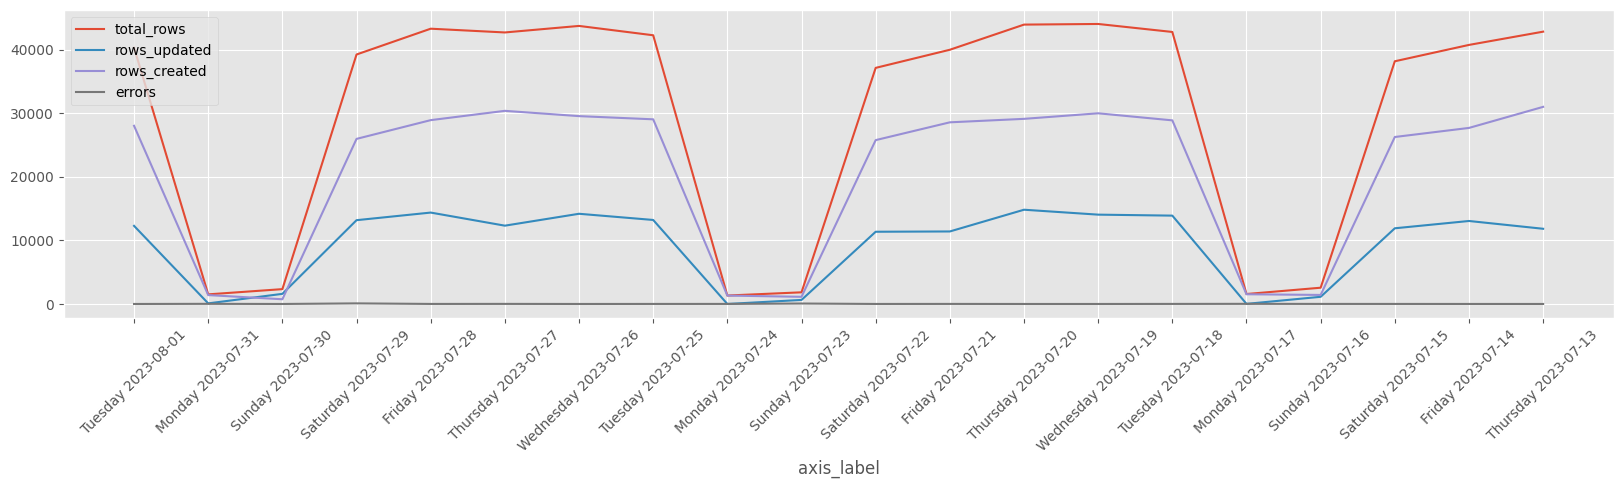

In [9]:
ax = df.plot(x='axis_label', y=['total_rows', 'rows_updated', 
                                'rows_created', 'errors'], rot=45, figsize=(20,4) )
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df['axis_label']);

There is seasonality here, a weekend lag with processing new filings. 

This correlation exists between all the continuous variables and the day of the week.

In [10]:
df.to_csv('./data/revisions_ACTUALS.csv')

### Bootstrapping the dataset  
This dataset must be bootstrapped in order to have enough observations for an anomaly detection model. Bootstrap method should be determined by the data type of the variable.

- Continuous variables:
    - total_rows
    - error_count
    - rows_updated
    - rows_created
    - errors  
 
We'll add in some logic to ensure that `rows_updated` and `rows_created` do not get bootstrapped with random numbers, but instead sum up to `total_rows`, which is what we would expect in the real world.

In [11]:
# create bootstrap samples
cols = ['total_rows', 'rows_updated', 'rows_created', 'errors']

def create_bootstrap_samples_mean(variable, sample_size = len(df), n_samples = 10000):
    
    sample_means = []
    
    for i in range(n_samples):

        # create a bootstrap sample of sample_size with replacement
        df_bootstrap_sample = df[variable].sample(n = sample_size, replace = True)

        # calculate the bootstrap sample mean
        sample_mean = df_bootstrap_sample.mean()

        # add this sample mean to the sample means list
        sample_means.append(sample_mean)
    
    return pd.Series(sample_means, name=variable)


# create bootstrap samples
bootstrapped_series = []

for variable in continuous_vars:
    bootstrapped_series.append(create_bootstrap_samples_mean(variable))
    
bootstrapped_df = pd.concat(bootstrapped_series, axis=1)
bootstrapped_df = bootstrapped_df.astype('int32')
bootstrapped_df.head()


# bootstrapped_df = df[cols].sample(n=1000, replace=True, random_state=42)
# bootstrapped_df = bootstrapped_df.astype('int32')
# bootstrapped_df = bootstrapped_df.reset_index(drop=True)

# bootstrapped_df

,total_rows,rows_updated,rows_created,errors
0,31814,9838,20136,12
1,32641,9818,17790,28
2,27080,10610,21726,5
3,33074,9262,19944,8
4,33387,10397,17988,7


In [12]:
bootstrapped_df.describe()

,total_rows,rows_updated,rows_created,errors
count,10000.000,10000.000,10000.000,10000.000
mean,29672.598,9282.843,20329.960,13.533
std,4112.869,1278.993,2799.736,5.254
min,13408.000,4257.000,8257.000,2.000
25%,27217.750,8459.750,18677.750,10.000
50%,29713.500,9302.000,20378.000,13.000
75%,32419.000,10171.000,22152.250,17.000
max,41974.000,13359.000,29638.000,39.000


In [13]:
df[cols].describe()

,total_rows,rows_updated,rows_created,errors
count,20.000,20.000,20.000,20.000
mean,29599.450,9262.050,20323.400,14.000
std,18729.524,5920.923,12877.728,24.251
min,1327.000,0.000,742.000,0.000
25%,2500.250,1475.000,1500.250,0.750
50%,40124.500,12088.000,27841.500,6.000
75%,42772.750,13377.250,29046.250,10.000
max,44016.000,14816.000,30986.000,93.000


In [14]:
# Format index as a datetimeindex and add 'update_date' back to the df

idx = pd.date_range(str(date.today()), periods=1000, freq="D")
base = date.today()
date_list = [base - datetime.timedelta(days=x) for x in range(1000)]

bootstrapped_df['date'] = pd.to_datetime(pd.Series(date_list))
bootstrapped_df.tail()

,total_rows,rows_updated,rows_created,errors,date
9995,32337,10932,23144,13,NaT
9996,33768,10004,19093,10,NaT
9997,31506,8422,19742,11,NaT
9998,26740,12189,21030,14,NaT
9999,34106,8851,20428,19,NaT


In [15]:
# Addtl. date columns
bootstrapped_df['day_of_week'] = bootstrapped_df['date'].dt.day_name()
bootstrapped_df['axis_label'] = bootstrapped_df['date'].apply(lambda x: str(x)[:10])
bootstrapped_df['axis_label'] = bootstrapped_df['day_of_week'] + " " + bootstrapped_df['axis_label']

bootstrapped_df.head()


,total_rows,rows_updated,rows_created,errors,date,day_of_week,axis_label
0,31814,9838,20136,12,2024-02-23,Friday,Friday 2024-02-23
1,32641,9818,17790,28,2024-02-22,Thursday,Thursday 2024-02-22
2,27080,10610,21726,5,2024-02-21,Wednesday,Wednesday 2024-02-21
3,33074,9262,19944,8,2024-02-20,Tuesday,Tuesday 2024-02-20
4,33387,10397,17988,7,2024-02-19,Monday,Monday 2024-02-19


In [16]:
bootstrapped_df.describe()

,total_rows,rows_updated,rows_created,errors,date
count,10000.000,10000.000,10000.000,10000.000,1000
mean,29672.598,9282.843,20329.960,13.533,2022-10-11 12:00:00
min,13408.000,4257.000,8257.000,2.000,2021-05-30 00:00:00
25%,27217.750,8459.750,18677.750,10.000,2022-02-03 18:00:00
50%,29713.500,9302.000,20378.000,13.000,2022-10-11 12:00:00
75%,32419.000,10171.000,22152.250,17.000,2023-06-18 06:00:00
max,41974.000,13359.000,29638.000,39.000,2024-02-23 00:00:00
std,4112.869,1278.993,2799.736,5.254,NaN


Distribution plots

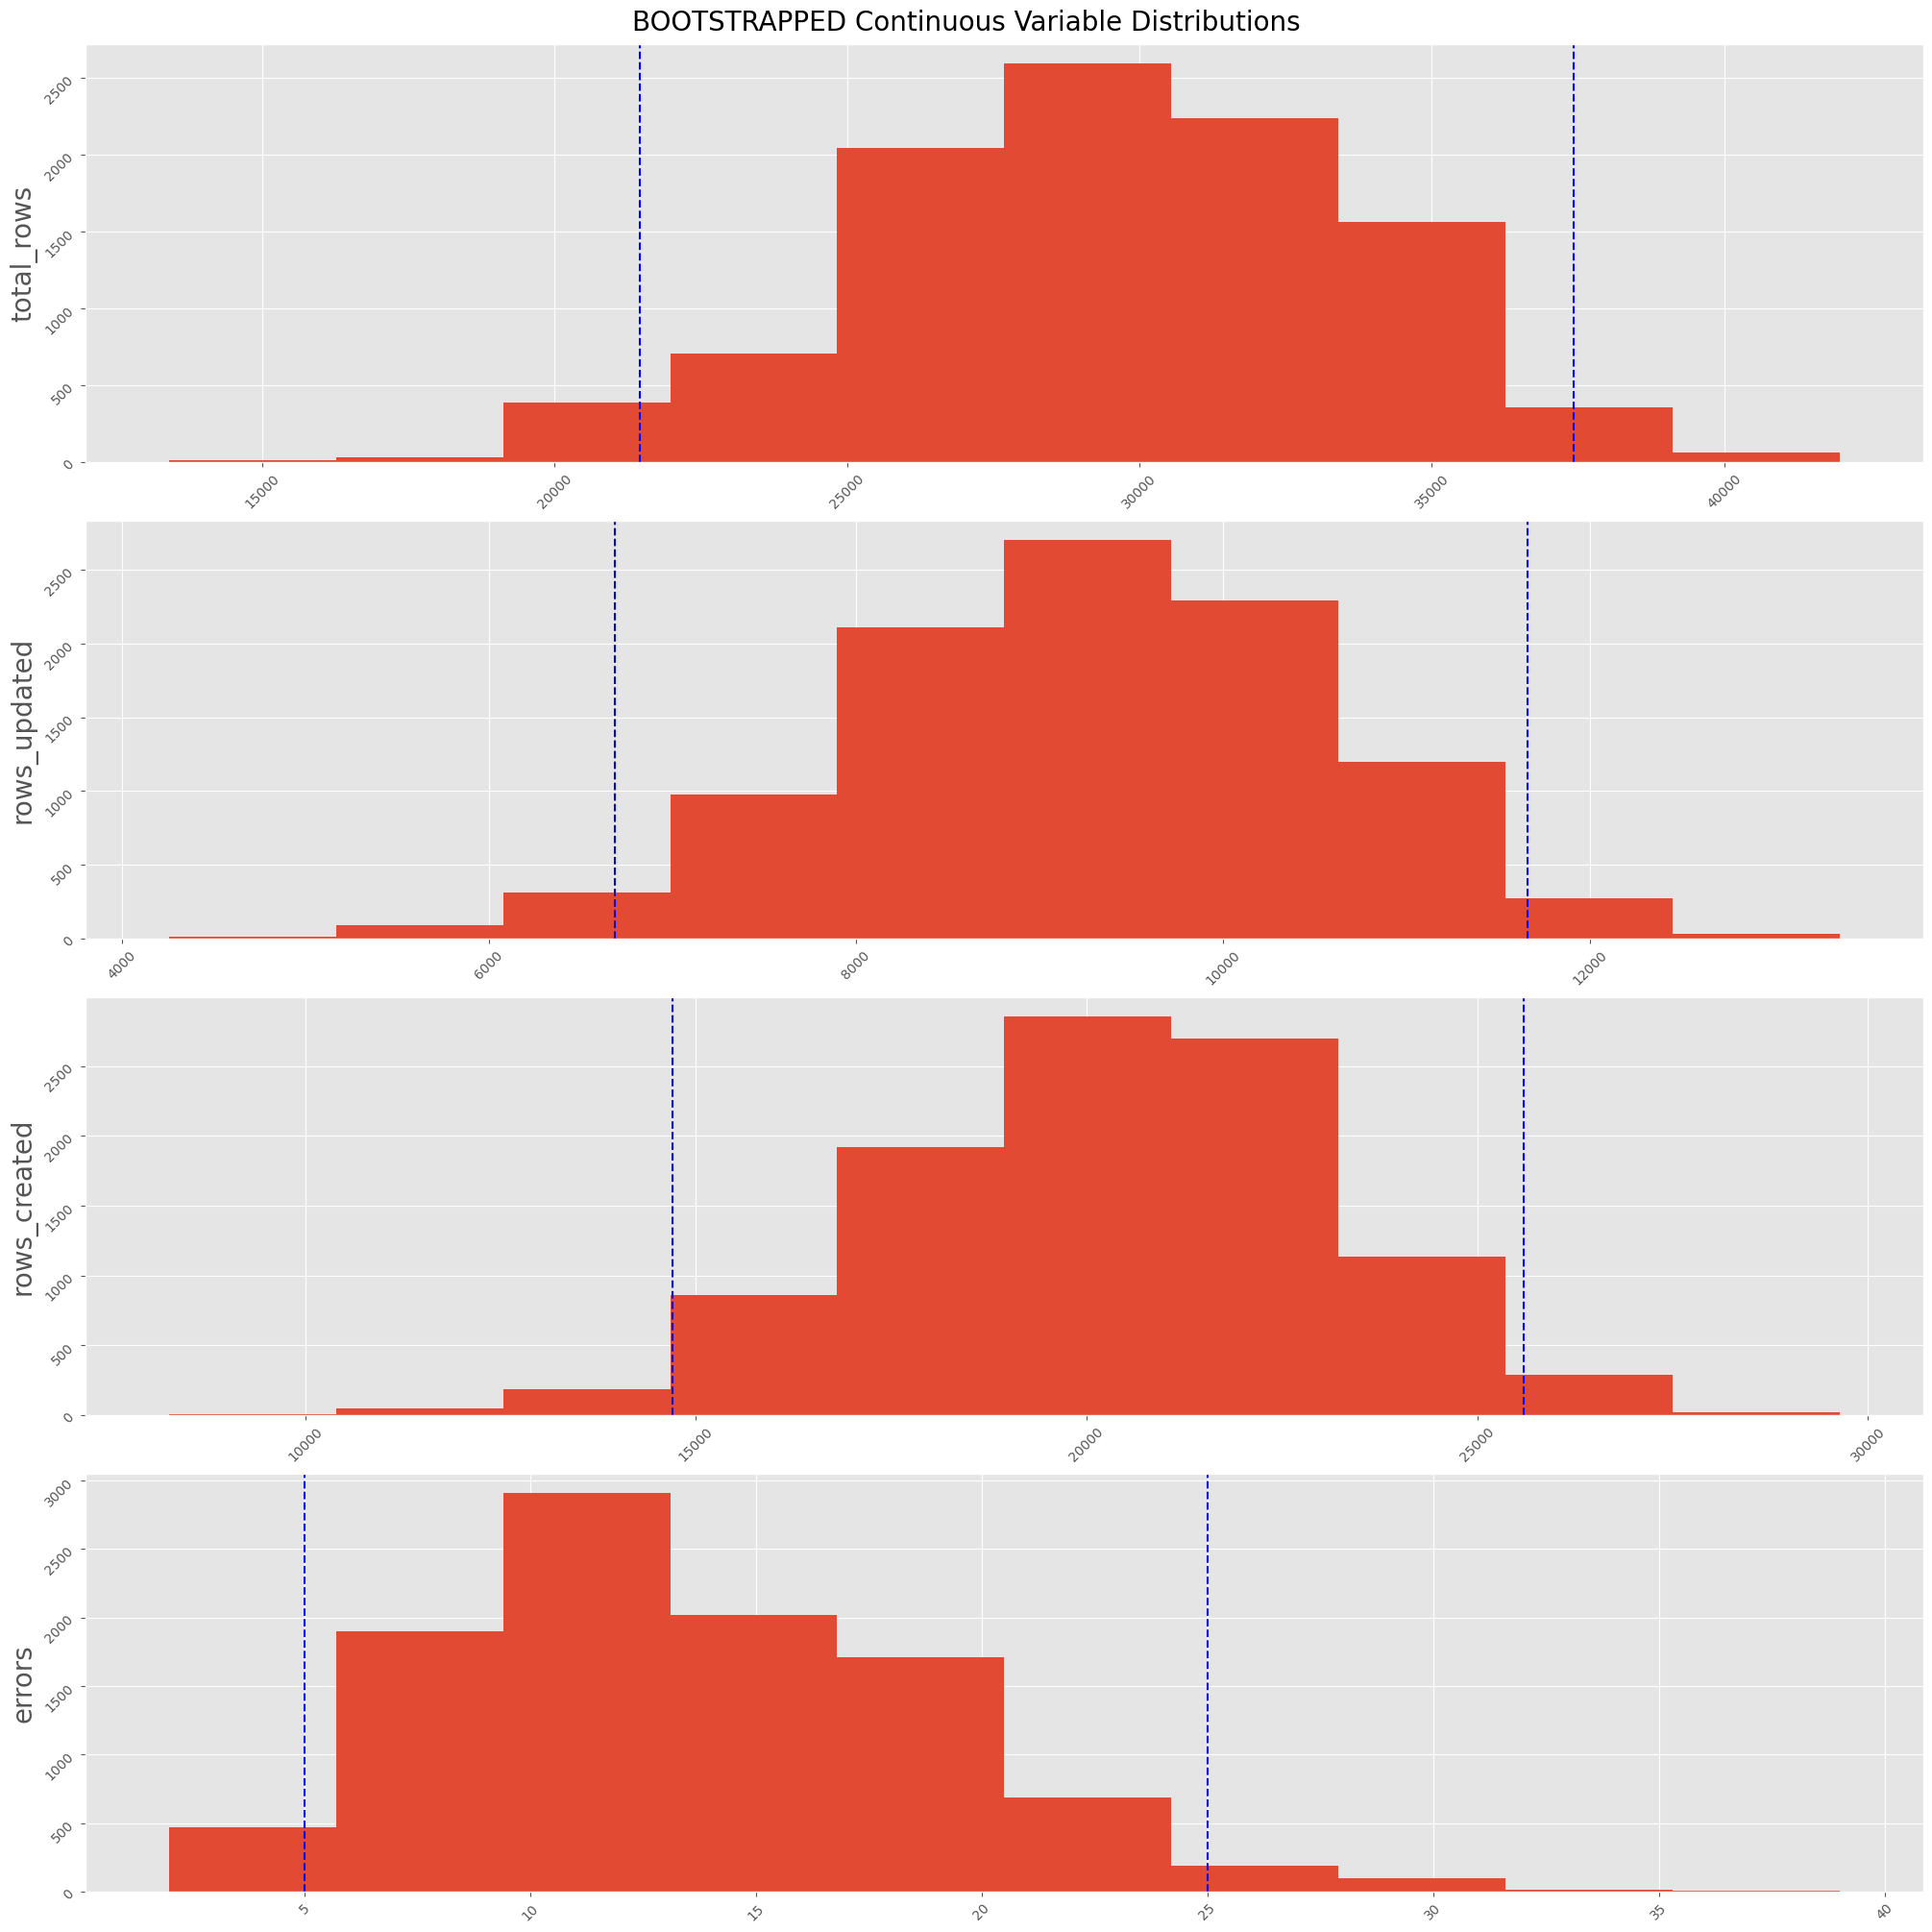

In [17]:
fig, axs = plt.subplots(4, figsize=(20, 20), constrained_layout = True)
fig.suptitle('BOOTSTRAPPED Continuous Variable Distributions', fontsize = 20)

for figure, variable in enumerate(continuous_vars):
    
    # get the lower and upper bounds of the confidence interval
    ci_lower = bootstrapped_df[variable].quantile(q = 0.025)
    ci_higher = bootstrapped_df[variable].quantile(q = 0.975)
    
    axs[figure].hist(bootstrapped_df[variable])
    axs[figure].tick_params(labelrotation=45)
    axs[figure].set_ylabel(variable, fontsize = 20)
    
    # add the lower bound and upper bound of the confidence interval
    axs[figure].axvline(ci_lower, color = 'blue', ls = '--')
    axs[figure].axvline(ci_higher, color = 'blue', ls = '--');

### Looking for extremes

Let's look at the weekend seasonality of the actuals data.  

When are the most rows created? The fewest?  

Consistently fewer rows are added to each update on Sundays and Mondays, with the other weekdays having consistently higher row counts of updates. Are there other patterns like this in the data? Can we understand the outliers for each continuous variable a little better?

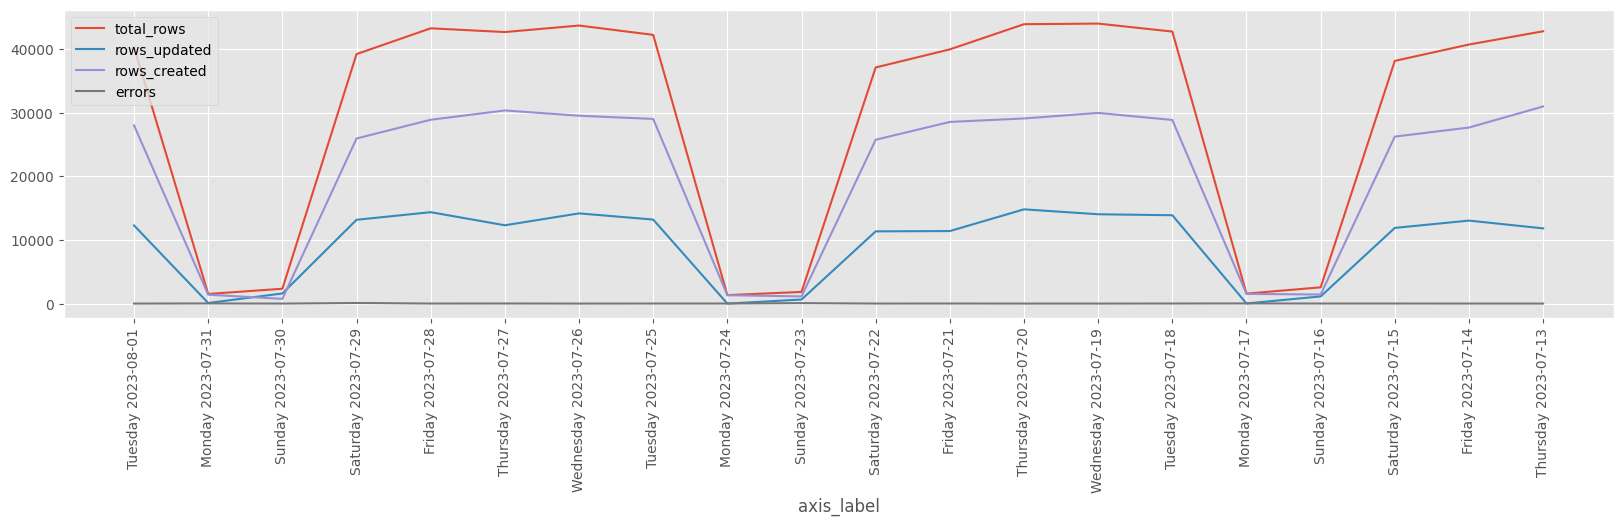

In [18]:
ax = df.plot(x='axis_label', y=['total_rows', 'rows_updated',
                                                  'rows_created', 'errors'], rot=90, figsize=(20,4) )
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df['axis_label']);

We should ensure that the pattern of fewer records being updated on Sundays and Mondays persists in the bootstrapped data.

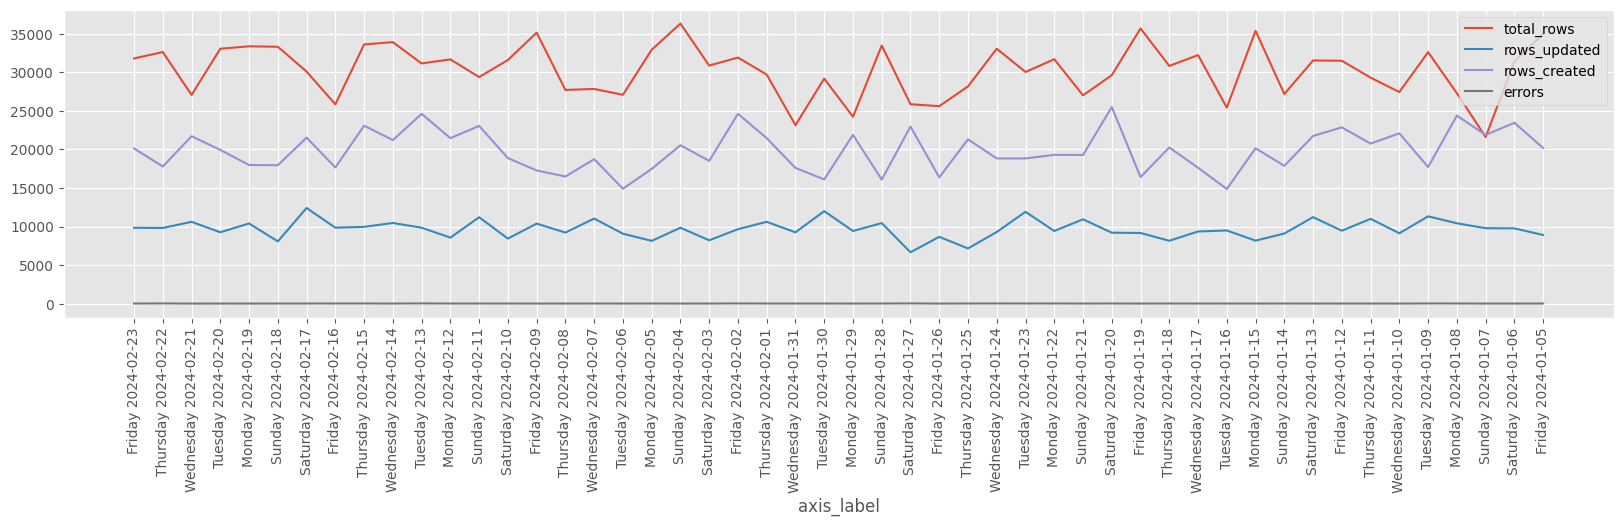

In [19]:
ax = bootstrapped_df.iloc[:50].plot(x='axis_label', y=['total_rows', 'rows_updated',
                                                  'rows_created', 'errors'], rot=90, figsize=(20,4) )
ax.set_xticks(range(len(bootstrapped_df.iloc[:50])))
ax.set_xticklabels(bootstrapped_df.iloc[:50]['axis_label']);

To create the Sunday / Monday effect that we see in the actuals data, we should decrease the values for this subset of rows in the bootstrapped data by some percentage. The % used here is the percentage decrease from the mean of the boostrapped columns to the mean of the actuals columns.

Since we have a mean of 0 for `error_count`, so we'll need to figure out a different approach for creating  anomalies for these columns.

In [20]:
print("Actuals Data")
print("------------")

actuals_sun_mon_df = pd.Series(df[df['day_of_week'].isin(['Sunday', 'Monday'])][continuous_vars].mean())
actuals_sun_mon_df


Actuals Data
------------


total_rows     1854.000
rows_updated    577.333
rows_created   1254.833
errors           21.833
dtype: float64

In [21]:
print("Bootstrapped Data")
print("-----------------")

bootstrapped_sun_mon_df = pd.Series(bootstrapped_df[bootstrapped_df['day_of_week'].isin(['Sunday', 'Monday'])][continuous_vars].mean())
bootstrapped_sun_mon_df

Bootstrapped Data
-----------------


total_rows     29577.888
rows_updated    9381.458
rows_created   20203.168
errors            13.469
dtype: float64

In [22]:
# Figure out the normalization factor for Sunday / Monday updates
# The 'norm_factor' is the difference between actuals and bootstrapped values on Sundays and Mondays, 
#       converted to a percentage

sun_mon_df = pd.concat([actuals_sun_mon_df, bootstrapped_sun_mon_df], axis=1)
sun_mon_df.columns = ['actuals_mean', 'bootstrapped_mean']
sun_mon_df['norm_factor'] = (100 - (((sun_mon_df['bootstrapped_mean'] - sun_mon_df['actuals_mean']) / sun_mon_df['bootstrapped_mean']) * 100))/100
sun_mon_df

,actuals_mean,bootstrapped_mean,norm_factor
total_rows,1854.000,29577.888,0.063
rows_updated,577.333,9381.458,0.062
rows_created,1254.833,20203.168,0.062
errors,21.833,13.469,1.621


In [23]:
# Initially applied the norm factor to 'rows_updated' and 'rows_created' as well, but results 
# didn't compare very well to the actuals data, so we'll inspect these columns another way.
vars_to_normalize = ['total_rows','errors']

# Apply the growth decrease to bootstrapped rows that occurred on Sundays and Mondays
for variable in vars_to_normalize:
    bootstrapped_df[variable] = np.where(bootstrapped_df['day_of_week'].isin(['Sunday', 'Monday']), 
                                                                             sun_mon_df.loc[variable, 'norm_factor'] * bootstrapped_df[variable], 
                                                                             bootstrapped_df[variable]).astype('int32')

# Once again, we need to keep the relationship between `total_rows`, `rows_updated`, and `rows_created`,
# so we'll adjust these numbers
bootstrapped_df['rows_created'] = bootstrapped_df['total_rows'].apply(lambda x: np.random.randint(0, x))
bootstrapped_df['rows_updated'] = bootstrapped_df['total_rows'] - bootstrapped_df['rows_created']

    

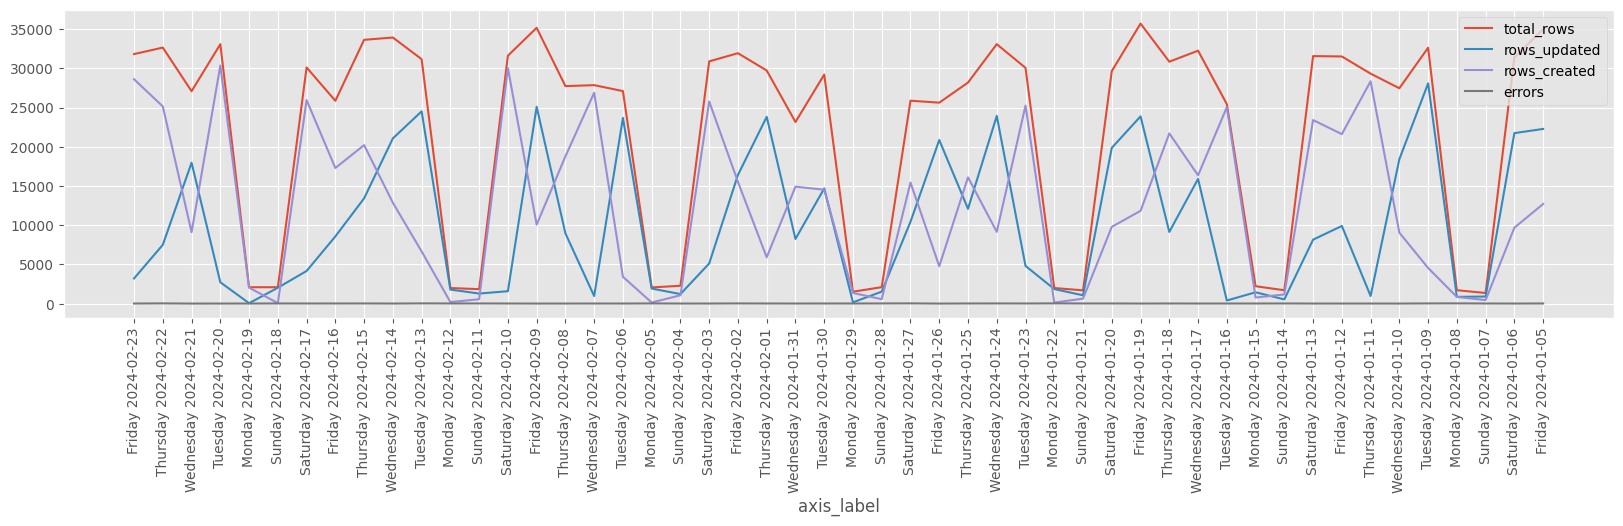

In [24]:
ax = bootstrapped_df.iloc[:50].plot(x='axis_label', y=['total_rows', 'rows_updated',
                                                  'rows_created', 'errors'], rot=90, figsize=(20,4) )
ax.set_xticks(range(len(bootstrapped_df.iloc[:50])))
ax.set_xticklabels(bootstrapped_df.iloc[:50]['axis_label']);

In [25]:

pd.concat([bootstrapped_df[bootstrapped_df['day_of_week'].isin(['Sunday', 'Monday'])][vars_to_normalize].describe(),
           df[df['day_of_week'].isin(['Sunday', 'Monday'])][vars_to_normalize].describe()], axis=1)
                                        

Bootstrapped values are on the left, actuals on the right


,total_rows,errors,total_rows,errors
count,286.000,286.000,6.000,6.000
mean,1853.514,21.346,1854.000,21.833
std,251.404,8.939,490.230,25.007
min,960.000,4.000,1327.000,0.000
25%,1712.250,14.500,1524.500,9.000
50%,1861.000,21.000,1698.500,15.000
75%,2051.500,27.000,2207.750,21.750
max,2488.000,48.000,2556.000,70.000


Looking at the individual variables over time

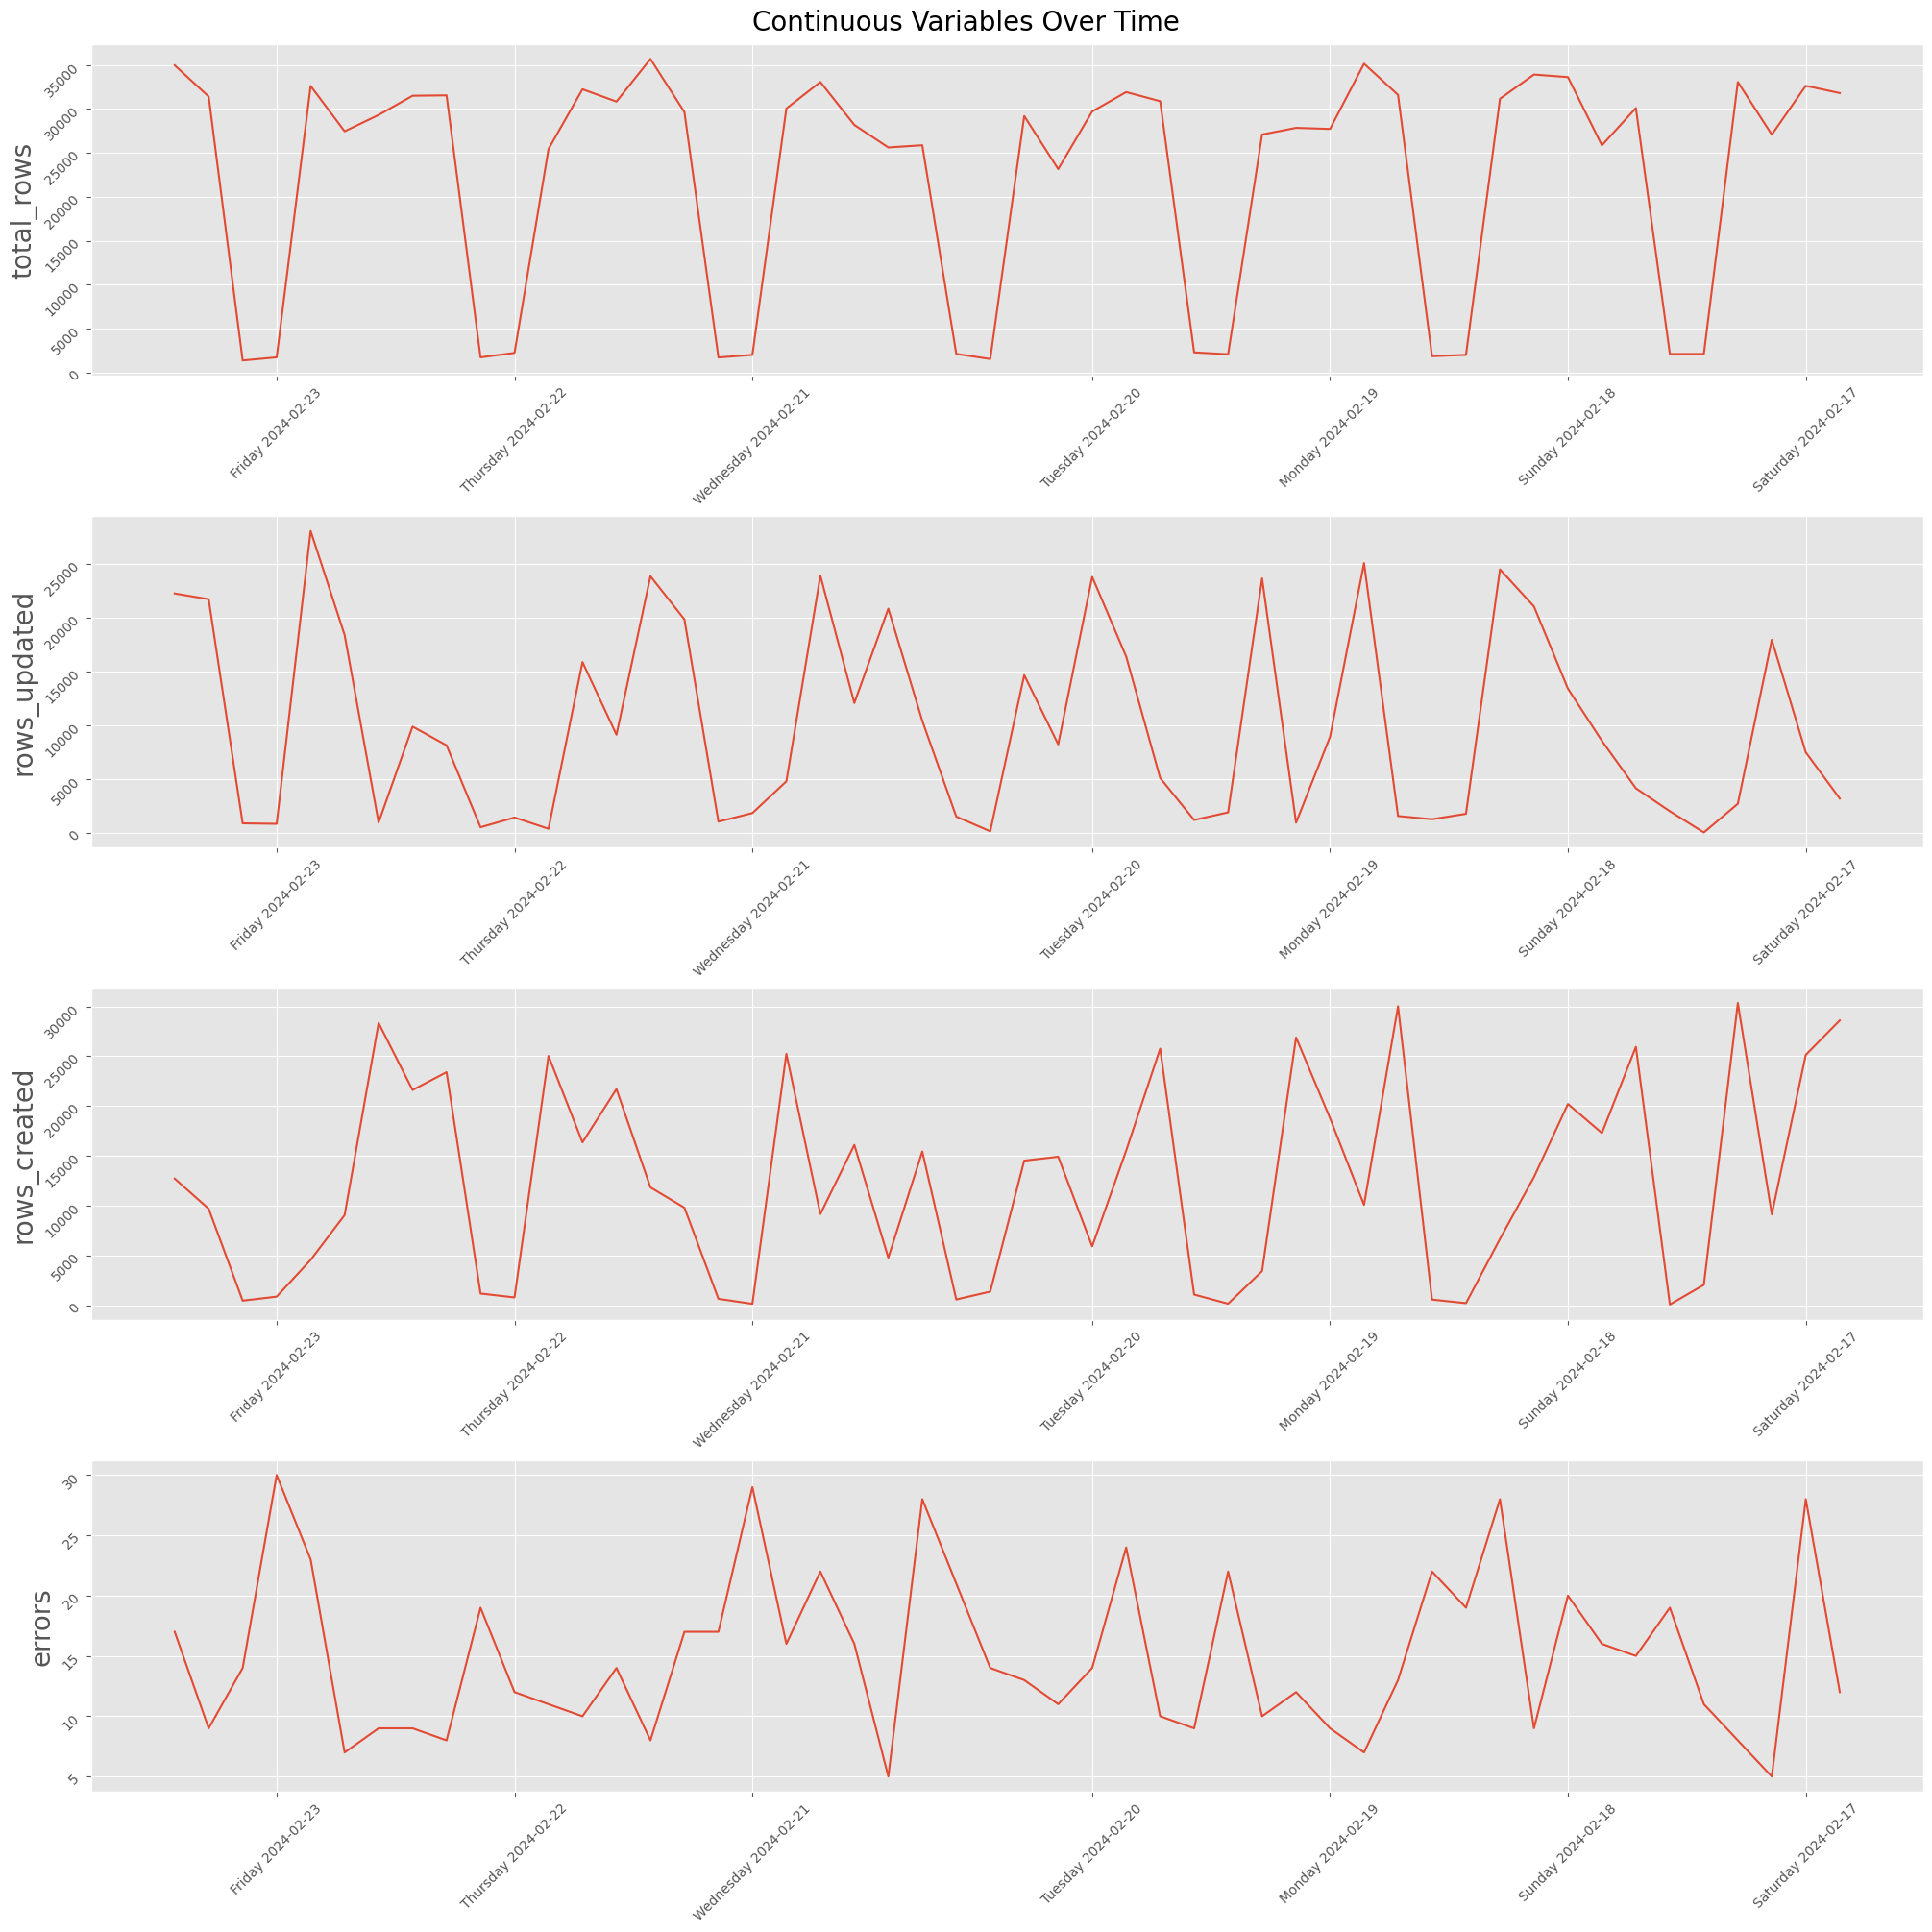

In [26]:
fig, axs = plt.subplots(4, figsize=(20, 20), constrained_layout = True)
fig.suptitle('Continuous Variables Over Time', fontsize = 20)

for figure, variable in enumerate(continuous_vars): 
    
    axs[figure].plot(bootstrapped_df['date'][:50], bootstrapped_df[variable][:50])
    axs[figure].set_ylabel(variable, fontsize = 20)
    axs[figure].tick_params(labelrotation=45)
    axs[figure].set_xticklabels(bootstrapped_df.iloc[:50]['axis_label']);

Compare the actuals to the bootstrapped records

Actuals vs Bootstrapped Data
(Bootstrapped values are on the left, actuals on the right)
bootstrapped df limited to 20 rows


<Figure size 640x480 with 0 Axes>

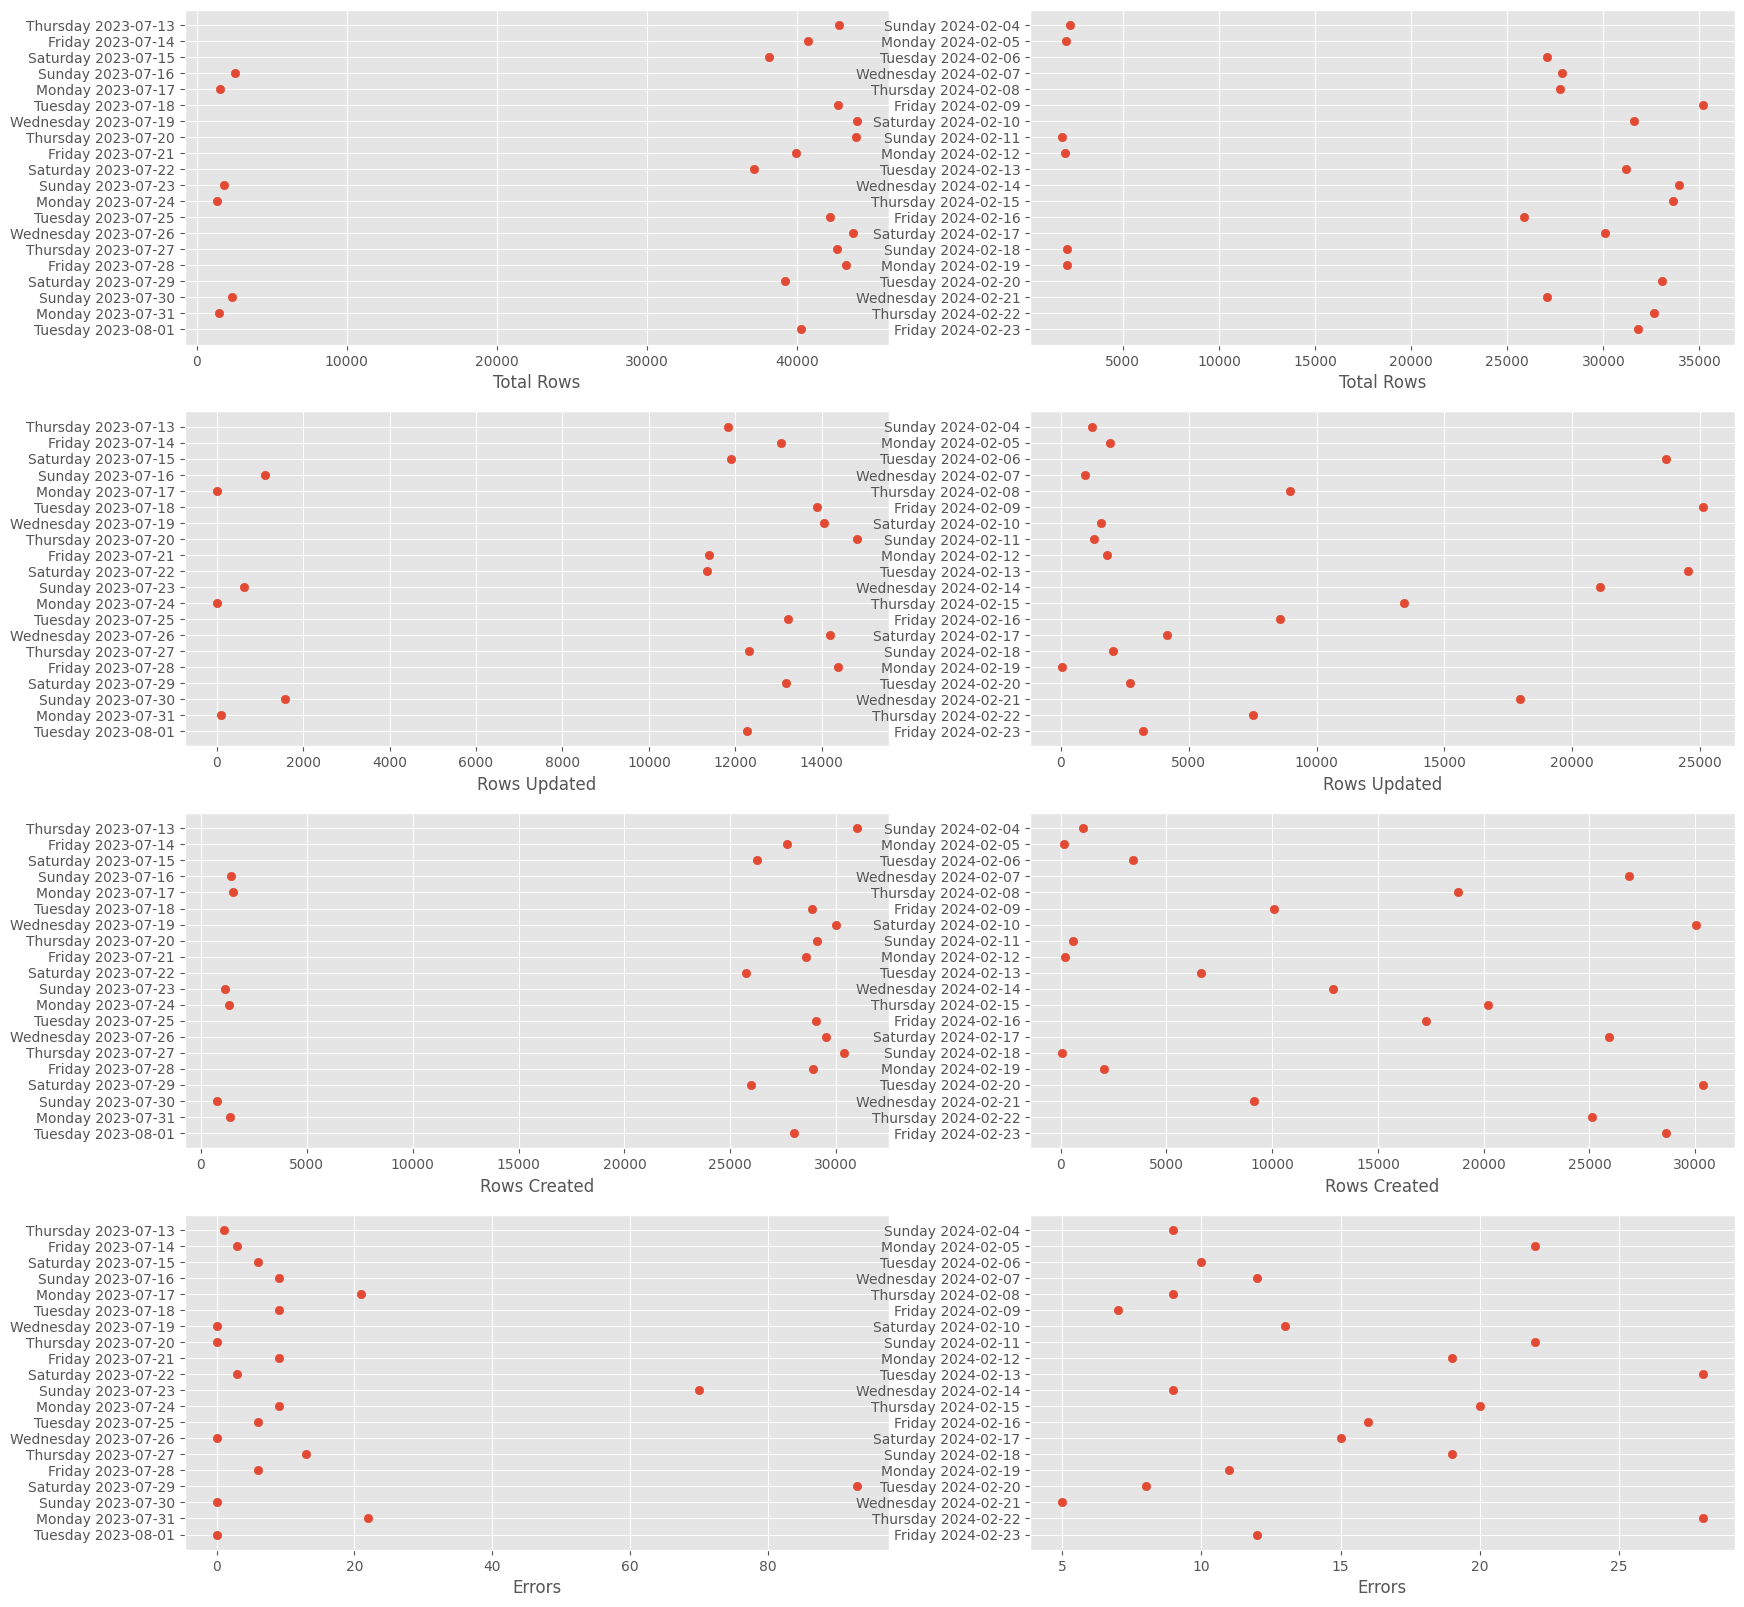

In [29]:
f = plt.figure()    
f, axes = plt.subplots(nrows = 4, ncols = 2, figsize=(20, 20))

axes[0][0].scatter(df['total_rows'], df['axis_label'])
axes[0][0].set_xlabel('Total Rows')

axes[0][1].scatter(bootstrapped_df['total_rows'][:20], bootstrapped_df['axis_label'][:20])
axes[0][1].set_xlabel('Total Rows')

axes[1][0].scatter(df['rows_updated'], df['axis_label'])
axes[1][0].set_xlabel('Rows Updated')

axes[1][1].scatter(bootstrapped_df['rows_updated'][:20], bootstrapped_df['axis_label'][:20])
axes[1][1].set_xlabel('Rows Updated')

axes[2][0].scatter(df['rows_created'], df['axis_label'])
axes[2][0].set_xlabel('Rows Created')

axes[2][1].scatter(bootstrapped_df['rows_created'][:20], bootstrapped_df['axis_label'][:20])
axes[2][1].set_xlabel('Rows Created')

axes[3][0].scatter(df['errors'], df['axis_label'])
axes[3][0].set_xlabel('Errors')

axes[3][1].scatter(bootstrapped_df['errors'][:20], bootstrapped_df['axis_label'][:20])
axes[3][1].set_xlabel('Errors');

print("Actuals vs Bootstrapped Data")
print("(Bootstrapped values are on the left, actuals on the right)")
print("bootstrapped df limited to 20 rows")

In [28]:
bootstrapped_df.to_csv('./data/revisions_BOOTSTRAPPED.csv', index=False)
